In [4]:
from collections import defaultdict, namedtuple
import concurrent.futures
from distribution import build_distribution_dict_for_str_features, build_precision_dict_for_num_features, pro_distribution_in_conditions, sample_from_dict
from model.gmm import estimate_gmm_probabilities, estimate_initiate_pro_distribution_for_num_features, safe_kde, estimate_conditional_distribution_KDE
from graph import build_graph_from_LLM_response, build_graph, remove_cycles, generate_dependencies
from joblib import Parallel, delayed
from lookup import filter_rows_by_column_for_str_features, filter_rows_by_column_for_num_features
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms import AffineCouplingTransform, ReversePermutation, CompositeTransform
from model.nf import SwiGLU, ContextNet, nearest_valid_value, predict 
import pandas as pd
import random
from str_num import is_number_regex, number_type_key
from scipy.stats import gaussian_kde
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import BallTree
from sklearn.linear_model import BayesianRidge
import time
from tqdm import tqdm
import torch
import torch.nn as nn
from topological_sort import topological_layers_from_dag
from utils import extract_keys, check_keys, save_to_csv, reverse_dependency_dict



dataset='mushroom'
train_set_pth='datasets/'+dataset+"/train.csv"

In [5]:
num_key, str_key=number_type_key(train_set_pth, verbose=True, blank="?")

The following features hold strings:['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
The following features hold numbers:['cap-diameter', 'stem-height', 'stem-width']


In [6]:
descriptions={"adult":'A dataset for people income.',\
              "heloc":"A dataset about Home Equity Line of Credit (HELOC)",\
             "house":"The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data.",\
             "iris":"The dataset includes three iris species.",
              "diabetes":"The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy.",
              "mushroom":"Dataset of simulated mushrooms for binary classification into edible and poisonous.",
             }

prompt= f'''
You are given a tabular dataset described as follows:
f{descriptions[dataset]}

The dataset contains the following features (numerical or categorical):
f{num_key + str_key}

Your task is to identify the constraints (feature dependencies) between features. For each target feature, list the features that determine or constrain it, using the following format:

Feature_Name: [Cause1->Feature_Name, Cause2->Feature_Name]

Use '->' to indicate a constraint (i.e., one feature constrains or determines another). If a feature is independent, return an empty list:
Feature_Name: []

Only return the constraint list for each feature. Do not include any explanation or additional text.
'''
print(prompt)


You are given a tabular dataset described as follows:
fDataset of simulated mushrooms for binary classification into edible and poisonous.

The dataset contains the following features (numerical or categorical):
f['cap-diameter', 'stem-height', 'stem-width', 'class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']

Your task is to identify the constraints (feature dependencies) between features. For each target feature, list the features that determine or constrain it, using the following format:

Feature_Name: [Cause1->Feature_Name, Cause2->Feature_Name]

Use '->' to indicate a constraint (i.e., one feature constrains or determines another). If a feature is independent, return an empty list:
Feature_Name: []

Only return the constraint list for each feature. Do not include any explana

In [7]:
response_income='''
age: []
fnlwgt: []
educational-num: [education->educational-num, age->educational-num]
capital-gain: [occupation->capital-gain, workclass->capital-gain, education->capital-gain, income->capital-gain]
capital-loss: [occupation->capital-loss, workclass->capital-loss, education->capital-loss, income->capital-loss]
hours-per-week: [occupation->hours-per-week, workclass->hours-per-week]
workclass: [occupation->workclass, income->workclass]
education: [educational-num->education]
marital-status: [age->marital-status, relationship->marital-status]
occupation: [education->occupation, age->occupation, workclass->occupation]
relationship: [marital-status->relationship, gender->relationship]
race: []
gender: []
native-country: []
income: [education->income, workclass->income, occupation->income, capital-gain->income, capital-loss->income, hours-per-week->income]
'''
response_heloc='''
ExternalRiskEstimate: [NumSatisfactoryTrades->ExternalRiskEstimate, PercentTradesNeverDelq->ExternalRiskEstimate, NumTotalTrades->ExternalRiskEstimate, NumTrades90Ever2DerogPubRec->ExternalRiskEstimate]
MSinceOldestTradeOpen: []
MSinceMostRecentTradeOpen: [MSinceOldestTradeOpen->MSinceMostRecentTradeOpen]
AverageMInFile: [MSinceOldestTradeOpen->AverageMInFile, MSinceMostRecentTradeOpen->AverageMInFile]
NumSatisfactoryTrades: [NumTotalTrades->NumSatisfactoryTrades, PercentTradesNeverDelq->NumSatisfactoryTrades]
NumTrades60Ever2DerogPubRec: [NumTotalTrades->NumTrades60Ever2DerogPubRec]
NumTrades90Ever2DerogPubRec: [NumTotalTrades->NumTrades90Ever2DerogPubRec]
PercentTradesNeverDelq: [NumSatisfactoryTrades->PercentTradesNeverDelq, NumTotalTrades->PercentTradesNeverDelq]
MSinceMostRecentDelq: [MSinceMostRecentTradeOpen->MSinceMostRecentDelq]
MaxDelq2PublicRecLast12M: [NumTrades60Ever2DerogPubRec->MaxDelq2PublicRecLast12M, NumTrades90Ever2DerogPubRec->MaxDelq2PublicRecLast12M]
MaxDelqEver: [MaxDelq2PublicRecLast12M->MaxDelqEver]
NumTotalTrades: [NumSatisfactoryTrades->NumTotalTrades, NumTrades60Ever2DerogPubRec->NumTotalTrades, NumTrades90Ever2DerogPubRec->NumTotalTrades]
NumTradesOpeninLast12M: [MSinceMostRecentTradeOpen->NumTradesOpeninLast12M, NumTotalTrades->NumTradesOpeninLast12M]
PercentInstallTrades: [NumInstallTradesWBalance->PercentInstallTrades, NumTotalTrades->PercentInstallTrades]
MSinceMostRecentInqexcl7days: []
NumInqLast6M: [MSinceMostRecentInqexcl7days->NumInqLast6M]
NumInqLast6Mexcl7days: [NumInqLast6M->NumInqLast6Mexcl7days]
NetFractionRevolvingBurden: [NumRevolvingTradesWBalance->NetFractionRevolvingBurden]
NetFractionInstallBurden: [NumInstallTradesWBalance->NetFractionInstallBurden]
NumRevolvingTradesWBalance: [NumTotalTrades->NumRevolvingTradesWBalance]
NumInstallTradesWBalance: [NumTotalTrades->NumInstallTradesWBalance]
NumBank2NatlTradesWHighUtilization: [NumRevolvingTradesWBalance->NumBank2NatlTradesWHighUtilization]
PercentTradesWBalance: [NumRevolvingTradesWBalance->PercentTradesWBalance, NumInstallTradesWBalance->PercentTradesWBalance, NumTotalTrades->PercentTradesWBalance]
RiskPerformance: [ExternalRiskEstimate->RiskPerformance, PercentTradesNeverDelq->RiskPerformance, NumTrades90Ever2DerogPubRec->RiskPerformance, MaxDelqEver->RiskPerformance, NetFractionRevolvingBurden->RiskPerformance, NumInqLast6M->RiskPerformance]
'''
response_house='''
longitude: []  
latitude: [longitude->latitude]  
housing_median_age: [longitude->housing_median_age, latitude->housing_median_age, ocean_proximity->housing_median_age]  
total_rooms: [population->total_rooms, households->total_rooms, median_income->total_rooms]  
total_bedrooms: [total_rooms->total_bedrooms, population->total_bedrooms, households->total_bedrooms]  
population: [households->population, total_rooms->population, total_bedrooms->population]  
households: [population->households, total_rooms->households, total_bedrooms->households]  
median_income: [longitude->median_income, latitude->median_income, ocean_proximity->median_income]  
median_house_value: [median_income->median_house_value, housing_median_age->median_house_value, ocean_proximity->median_house_value, latitude->median_house_value, longitude->median_house_value]  
ocean_proximity: [longitude->ocean_proximity, latitude->ocean_proximity]
'''
response_iris='''
SepalLengthCm: []
SepalWidthCm: []
PetalLengthCm: []
PetalWidthCm: []
Species: [SepalLengthCm->Species, SepalWidthCm->Species, PetalLengthCm->Species, PetalWidthCm->Species]
'''
response_diabetes='''
Diabetes_012: [HighBP->Diabetes_012, HighChol->Diabetes_012, BMI->Diabetes_012, Smoker->Diabetes_012, Stroke->Diabetes_012, HeartDiseaseorAttack->Diabetes_012, PhysActivity->Diabetes_012, Fruits->Diabetes_012, Veggies->Diabetes_012, HvyAlcoholConsump->Diabetes_012, GenHlth->Diabetes_012, MentHlth->Diabetes_012, PhysHlth->Diabetes_012, DiffWalk->Diabetes_012, Age->Diabetes_012, Sex->Diabetes_012, Income->Diabetes_012, Education->Diabetes_012]

HighBP: [BMI->HighBP, Age->HighBP, Sex->HighBP, PhysActivity->HighBP, HeartDiseaseorAttack->HighBP, GenHlth->HighBP, Income->HighBP]

HighChol: [BMI->HighChol, Age->HighChol, HighBP->HighChol, PhysActivity->HighChol, GenHlth->HighChol, Income->HighChol]

CholCheck: [AnyHealthcare->CholCheck, Income->CholCheck, Education->CholCheck]

BMI: [PhysActivity->BMI, Fruits->BMI, Veggies->BMI, Sex->BMI, Age->BMI]

Smoker: [Age->Smoker, Sex->Smoker, Education->Smoker, Income->Smoker]

Stroke: [HighBP->Stroke, HeartDiseaseorAttack->Stroke, Age->Stroke, GenHlth->Stroke, BMI->Stroke]

HeartDiseaseorAttack: [HighBP->HeartDiseaseorAttack, HighChol->HeartDiseaseorAttack, Stroke->HeartDiseaseorAttack, Age->HeartDiseaseorAttack, BMI->HeartDiseaseorAttack]

PhysActivity: [Age->PhysActivity, Sex->PhysActivity, Income->PhysActivity, Education->PhysActivity]

Fruits: [Income->Fruits, Education->Fruits, Sex->Fruits]

Veggies: [Income->Veggies, Education->Veggies, Sex->Veggies]

HvyAlcoholConsump: [Sex->HvyAlcoholConsump, Age->HvyAlcoholConsump, Income->HvyAlcoholConsump]

AnyHealthcare: [Income->AnyHealthcare, Education->AnyHealthcare]

NoDocbcCost: [Income->NoDocbcCost, AnyHealthcare->NoDocbcCost]

GenHlth: [PhysHlth->GenHlth, MentHlth->GenHlth, DiffWalk->GenHlth]

MentHlth: [Income->MentHlth, Age->MentHlth, Sex->MentHlth]

PhysHlth: [Age->PhysHlth, Income->PhysHlth, Sex->PhysHlth]

DiffWalk: [Age->DiffWalk, BMI->DiffWalk, HeartDiseaseorAttack->DiffWalk]

Sex: []

Age: []

Education: []

Income: []
'''
response_mushroom='''
cap-diameter: []
stem-height: []
stem-width: []
class: [cap-shape->class, cap-surface->class, cap-color->class, does-bruise-or-bleed->class, gill-attachment->class, gill-spacing->class, gill-color->class, stem-root->class, stem-surface->class, stem-color->class, veil-type->class, veil-color->class, has-ring->class, ring-type->class, spore-print-color->class, habitat->class, season->class]
cap-shape: []
cap-surface: []
cap-color: []
does-bruise-or-bleed: []
gill-attachment: []
gill-spacing: []
gill-color: []
stem-root: []
stem-surface: []
stem-color: []
veil-type: []
veil-color: []
has-ring: []
ring-type: []
spore-print-color: []
habitat: []
season: []
'''
response=response_mushroom
response='\n'.join([i for i in response.split('\n') if i])

In [8]:
dependencies=build_graph_from_LLM_response(response, num_key+str_key)  

{'cap-diameter': [''],
 'stem-height': [''],
 'stem-width': [''],
 'class': ['cap-shape',
  'cap-surface',
  'cap-color',
  'does-bruise-or-bleed',
  'gill-attachment',
  'gill-spacing',
  'gill-color',
  'stem-root',
  'stem-surface',
  'stem-color',
  'veil-type',
  'veil-color',
  'has-ring',
  'ring-type',
  'spore-print-color',
  'habitat',
  'season'],
 'cap-shape': [''],
 'cap-surface': [''],
 'cap-color': [''],
 'does-bruise-or-bleed': [''],
 'gill-attachment': [''],
 'gill-spacing': [''],
 'gill-color': [''],
 'stem-root': [''],
 'stem-surface': [''],
 'stem-color': [''],
 'veil-type': [''],
 'veil-color': [''],
 'has-ring': [''],
 'ring-type': [''],
 'spore-print-color': [''],
 'habitat': [''],
 'season': ['']}

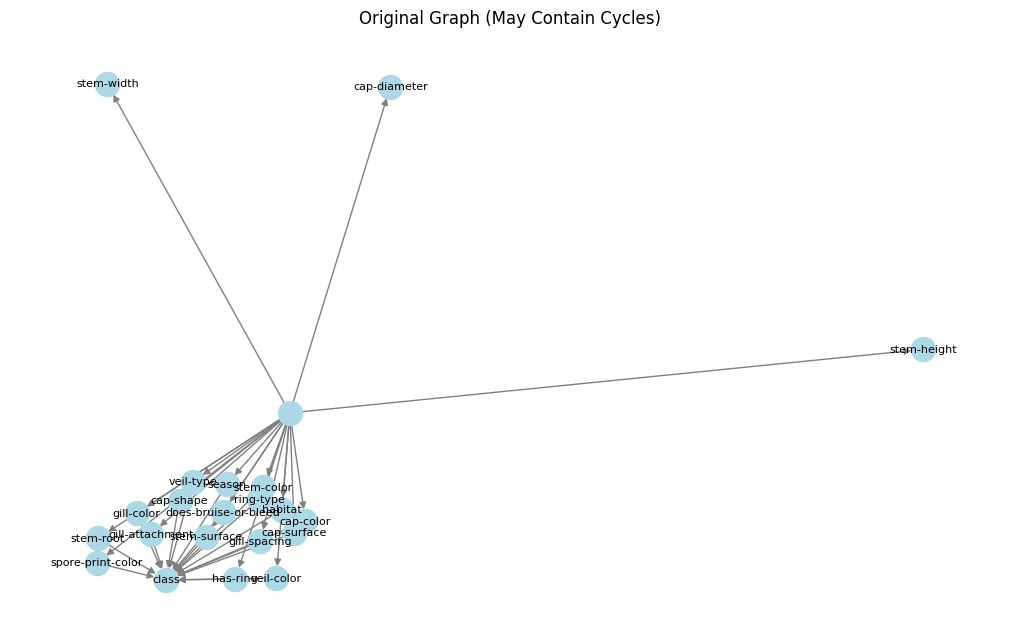

In [9]:
G = build_graph(dependencies)

plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', font_size=8)
plt.title("Original Graph (May Contain Cycles)")
plt.show()

Restricted license - for non-production use only - expires 2026-11-23


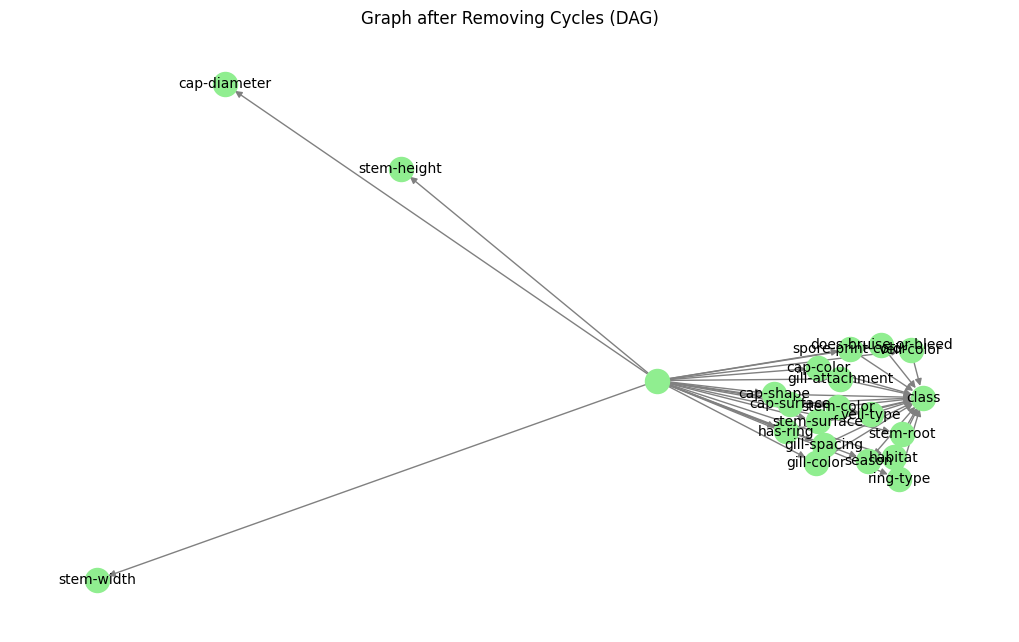

In [10]:
method='ilp' 
DAG = remove_cycles(G, method)
plt.figure(figsize=(10, 6))
nx.draw(DAG, with_labels=True, node_color='lightgreen', edge_color='gray', font_size=10)
plt.title("Graph after Removing Cycles (DAG)")
plt.show()

In [11]:

dependencies = generate_dependencies(DAG)

dependencies={key:dependencies[key] for key in dependencies if key}
dependencies            

{'cap-diameter': [''],
 'stem-height': [''],
 'stem-width': [''],
 'cap-shape': [''],
 'class': ['cap-shape',
  'cap-surface',
  'cap-color',
  'does-bruise-or-bleed',
  'gill-attachment',
  'gill-spacing',
  'gill-color',
  'stem-root',
  'stem-surface',
  'stem-color',
  'veil-type',
  'veil-color',
  'has-ring',
  'ring-type',
  'spore-print-color',
  'habitat',
  'season'],
 'cap-surface': [''],
 'cap-color': [''],
 'does-bruise-or-bleed': [''],
 'gill-attachment': [''],
 'gill-spacing': [''],
 'gill-color': [''],
 'stem-root': [''],
 'stem-surface': [''],
 'stem-color': [''],
 'veil-type': [''],
 'veil-color': [''],
 'has-ring': [''],
 'ring-type': [''],
 'spore-print-color': [''],
 'habitat': [''],
 'season': ['']}

In [12]:

layers = topological_layers_from_dag(DAG, keys=num_key+str_key) 


for i, layer in enumerate(layers):
    print(f"Layer {i}: {layer}")

Layer 0: ['cap-diameter', 'stem-height', 'stem-width', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
Layer 1: ['class']


In [16]:

df=pd.read_csv(train_set_pth)
str_pro_dis=build_distribution_dict_for_str_features(df, str_key, verbose=True) 

num_pre_dis=build_precision_dict_for_num_features(df, num_key, verbose=True) 

num_pre_dis

{'cap-diameter': {'min': 0.38, 'max': 62.34, 'precision': 0.00999999999999801},
 'stem-height': {'min': 0.0, 'max': 33.92, 'precision': 0.00999999999999801},
 'stem-width': {'min': 0.0, 'max': 103.91, 'precision': 0.009999999999990905}}

In [17]:
num_pro_dis=estimate_initiate_pro_distribution_for_num_features(df, num_key, num_pre_dis, verbose=True, n_components=3)

In [18]:
walk_graph = reverse_dependency_dict(dependencies)
walk_graph

{'cap-shape': ['class'],
 'cap-surface': ['class'],
 'cap-color': ['class'],
 'does-bruise-or-bleed': ['class'],
 'gill-attachment': ['class'],
 'gill-spacing': ['class'],
 'gill-color': ['class'],
 'stem-root': ['class'],
 'stem-surface': ['class'],
 'stem-color': ['class'],
 'veil-type': ['class'],
 'veil-color': ['class'],
 'has-ring': ['class'],
 'ring-type': ['class'],
 'spore-print-color': ['class'],
 'habitat': ['class'],
 'season': ['class'],
 'cap-diameter': [],
 'stem-height': [],
 'stem-width': [],
 'class': []}

In [19]:
back_up_dep=dependencies.copy()
for key in dependencies:
    print(key, dependencies[key])

cap-diameter ['']
stem-height ['']
stem-width ['']
cap-shape ['']
class ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
cap-surface ['']
cap-color ['']
does-bruise-or-bleed ['']
gill-attachment ['']
gill-spacing ['']
gill-color ['']
stem-root ['']
stem-surface ['']
stem-color ['']
veil-type ['']
veil-color ['']
has-ring ['']
ring-type ['']
spore-print-color ['']
habitat ['']
season ['']


In [20]:
dep_steps=1

if dep_steps>1:
    tmp_dependencies=dependencies
    for _ in range(dep_steps-1):
        for node in dependencies:
            for n in dependencies[node]:
                if n:
                    tmp_dependencies[node]+=dependencies[n]
            if "" in tmp_dependencies[node]:
                tmp_dependencies[node].remove("")
            if node in tmp_dependencies[node]:
                tmp_dependencies[node].remove(node)
            tmp_dependencies[node]=list(set(tmp_dependencies[node]))
        dependencies=tmp_dependencies

In [21]:
back_up_dep==dependencies

True

In [22]:
early_stop=True
patient=500
epoch_num=5000
Interleaved_Mask=False
ModelWrapper = namedtuple("ModelWrapper", ["type", "model"])

df_flow=df.copy()
target_features = [k for k, v in dependencies.items() if v and k in num_key]

print(target_features)

scalers = {}
encoders = {}
for feature in num_key:
    scaler = StandardScaler()
    df_flow[feature] = scaler.fit_transform(df_flow[[feature]])
    scalers[feature] = scaler

for feature in str_key:  
    encoder = LabelEncoder()
    df_flow[feature] = encoder.fit_transform(df_flow[feature])  
    encoders[feature] = encoder 
    
trained_models = {}
start_time = time.time()

for target in target_features:
    if early_stop:
        b_loss=float("inf")
        count=0
    conditions = dependencies[target]
    conditions = [c for c in conditions if c in df_flow.columns] 

    if not conditions:
        continue

    X = df_flow[conditions].values
    Y = df_flow[[target]].values
    
    if len(conditions) == 1:
        X = df_flow[conditions].values
        Y = df_flow[[target]].values
        model = make_pipeline(PolynomialFeatures(10), BayesianRidge())
        
        model.fit(X, Y.ravel())
        print(f"{target} | Gaussian fitting.")
        trained_models[target] = ModelWrapper("gaussian", model)
    else:

        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)
    

        base_dist = StandardNormal(shape=(1,))
    
        num_features=X.shape[1]
        if Interleaved_Mask:

            mask = torch.tensor([1, 0] * (num_features // 2) + [1] * (num_features % 2))
            transforms = [
                ReversePermutation(features=1),
                AffineCouplingTransform(
                    mask=mask, 
                    transform_net_create_fn=lambda in_features, out_features: ContextNet(in_features, out_features, context_features=X.shape[1])
                )
            ]
        else:
            transforms = [
                ReversePermutation(features=1),
                AffineCouplingTransform(mask=torch.tensor([1]), \
                                        transform_net_create_fn=lambda in_features, out_features: \
                                                                    ContextNet(in_features, out_features, context_features=X.shape[1])
                                        )
                        ]
        flow = Flow(CompositeTransform(transforms), base_dist)

        optimizer = torch.optim.AdamW(flow.parameters(), lr=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
        for epoch in range(epoch_num):
            optimizer.zero_grad()
            log_prob = flow.log_prob(Y, context=X)
            loss = -log_prob.mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
                
            if float(loss.item()) < b_loss:
                b_loss = float(loss.item())
                count = 0
            else:
                count += 1
                if early_stop and count >= patient:
                    print(f"Early stopped at epoch {epoch}, best loss: {b_loss}")
                    break
        
            if epoch % 100 == 0:
                print(f"{target} | Epoch {epoch}, Loss: {loss.item()}")

        trained_models[target] = ModelWrapper("flow", flow)

end_time = time.time()
print(f"Time cost: {(end_time - start_time)} s.")

['cap-diameter', 'stem-height', 'stem-width']
Time cost: 0.00046372413635253906 s.


In [23]:
SAMPLE_NUMS = 12000
N = 1  
T = 1
KDE=False  
bw_method="silverman"


if SAMPLE_NUMS<=len(df):
    epoch_num=1
else:
    epoch_num=SAMPLE_NUMS//len(df)+1
    SAMPLE_NUMS=len(df)-1
    
Tree=True


if Tree:
    print("Building Ball Tree..")
    trees={}
    for key in num_key:
        trees[key] = BallTree(df[[key]].to_numpy(), leaf_size=40)  
    print("Finished.")
else:
    trees=None

print("Start Generating..")

def generate_sample(i):
    selected_sample = df.iloc[sample_indices[i]].to_dict()

    node = random.choice(layers[0]) 
    if node in str_key:
        generated_value = sample_from_dict(str_pro_dis[node], top_p=None)
    elif node in num_key:
        generated_value = sample_from_dict(num_pro_dis[node], top_p=None)
    selected_sample[node] = generated_value

    nodes = walk_graph[node]
    while nodes:
        nodes_next_turn = []
        for node in nodes:
            conditional_keys = dependencies[node]
            if KDE:
                CN = N
                max_count = 5
                c_count = 0
                while c_count < max_count:
                    result = estimate_conditional_distribution_KDE(
                        df, num_key, str_key,
                        {key: selected_sample[key] for key in conditional_keys},
                        num_pre_dis, node, N=CN, trees=trees,
                        method='kde', bw_method=bw_method                                  
                    )
                    if result:
                        break
                    else:
                        CN *= 2
                        c_count += 1
                if result:
                    selected_sample[node] = sample_from_dict(result, top_p=None, temperature=T)
            else:
                if node in trained_models:
                    
                    inputs = {}
                    for conditional_key in conditional_keys:
                        inputs[conditional_key]=selected_sample[conditional_key]

                    result = predict(node, inputs, dependencies,  num_pre_dis[node])

                    if result is not None:
                        selected_sample[node] = result
                    else:
                        raise Exception("No result.")
                else:
                    CN = N
                    max_count = 5
                    c_count = 0
                    while c_count < max_count:
                        result = estimate_conditional_distribution_KDE(
                            df, num_key, str_key,
                            {key: selected_sample[key] for key in conditional_keys},
                            num_pre_dis, node, N=CN, trees=trees,
                            method='kde', bw_method=bw_method                                  
                        )
                        if result:
                            break
                        else:
                            CN *= 2
                            c_count += 1
                    if result:
                        selected_sample[node] = sample_from_dict(result, top_p=None, temperature=T)
    
            nodes_next_turn += walk_graph[node]
        nodes = nodes_next_turn
    return selected_sample
    
generated_samples=[]
start_time = time.time()

for epoch in range(epoch_num):
    print(f"Epoch: {epoch}/{epoch_num}")
    sample_indices = random.sample(range(len(df)), SAMPLE_NUMS)
    with concurrent.futures.ProcessPoolExecutor(max_workers=32) as executor:
        generated_samples += list(tqdm(executor.map(generate_sample, range(SAMPLE_NUMS)), total=SAMPLE_NUMS))

end_time = time.time()
print(f"Time cost: {(end_time - start_time) / SAMPLE_NUMS / epoch_num * 1000} ms.")

Building Ball Tree..
Finished.
Start Generating..
Epoch: 0/1


100%|█████████████████████████████████████████████████████████████████████████████| 12000/12000 [02:25<00:00, 82.60it/s]


Time cost: 12.225468933582306 ms.


In [24]:
remove_training_repeat=False

tmp_l=[]
ori_l=[df.iloc[i].to_dict() for i in range(len(df))]
for sample in generated_samples:
    if sample not in tmp_l:
        if remove_training_repeat:
            if sample not in ori_l:
                tmp_l.append(sample)
        else:
            tmp_l.append(sample)
generated_samples=tmp_l
print(f"Remaining rate: {round(len(generated_samples)/SAMPLE_NUMS/epoch_num*100, 2)}")
print(f"Generation size: {len(generated_samples)}")

Remaining rate: 100.0
Generation size: 12000


In [25]:
template=df.iloc[0].to_dict()
cleaned_outputs=[]
for sample in generated_samples:
    if sample:
        co={}
        for key in template:
            if key in num_key:
                if int(sample[key])==sample[key]:
                    co[key]=int(sample[key])
                else:
                    co[key]=sample[key]
            else:
                co[key]=sample[key]
        cleaned_outputs.append(co)
save_to_csv(cleaned_outputs, filename='datasets/'+dataset+"/"+"ILP_FLOW_12000_12.csv")

Data save to datasets/mushroom/ILP_FLOW_12000_12.csv.
